## Part 2 - Dealing with Missing Data


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from rfpimp import * 

In [2]:
def evaluate(X, y, n_estimators=50):
    rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 is {oob:.5f} using {n:,d} tree nodes with {h} median tree depth")
    return rf, oob

In [3]:
def showimp(rf, X, y):
    features = list(X.columns)
    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')

In [4]:
from pandas.api.types import is_string_dtype, is_object_dtype

def df_normalize_strings(df):
    for col in df.columns:
        if is_string_dtype(df[col]) or is_object_dtype(df[col]):
            df[col] = df[col].str.lower()
            df[col] = df[col].fillna(np.nan)
            df[col] = df[col].replace('none or unspecified', np.nan)
            df[col] = df[col].replace('none', np.nan)
            df[col] = df[col].replace('#name?', np.nan)
            df[col] = df[col].replace('', np.nan)

In [5]:
def extract_sizes(df, colname):
    df[colname] = df[colname].str.extract('(\d+\.\d+|\d+)', expand=True)
    df[colname] = df[colname].replace('', np.nan)
    df[colname] = pd.to_numeric(df[colname])

In [6]:
def parse_length(length):
    if pd.isnull(length):
        return np.nan
    else:
      split_length = length.split("' ")
      feet = float(split_length[0])
      inches = float(split_length[1].replace("\"",""))
      return (12*feet) + inches

### Recap

It is a good idea to recap what we did to the data last time:

- dropped the `SalesID` and `MachineID` features;
- converted `auctioneerID` to 'string' data type so we can treat it as a categorical feature;
- decided to leave `Blade_Width` as 'string' and treat as a categorical feature instead of converting to numeric;
- extracted numeric features from the original `Undercarriage_Pad_Width` and `Tire_Size` strings;
- converted `Stick_Length` to a numeric feature from the original string representation;
- normalized the representation of missing values to `np.nan`.

### Next Steps

Our next steps will be to carry out the following:
- convert all 'string' features to ordered categorical features;
- label encode all these features using the value of 0 to represent missing data;
- fix some remaining problems with numeric columns; and 
- replace missing numeric data by:
    - adding a new feature to say whether or not that value was missing; 
    - replace missing values in the original feature with the median of all values for that feature.

### Reset Data

In this notebook we are going to pick up where we left off in **Part 1** so we'll load and process the data according to what we did in the last notebook. 

In [18]:
df_raw = pd.read_feather("bulldozer-train.feather")
df = df_raw.copy()
df = df.iloc[-100000:]

In [19]:
df.drop(['SalesID', 'MachineID'], axis=1, inplace=True)
df['auctioneerID'] = df['auctioneerID'].astype(str)
df_normalize_strings(df)
extract_sizes(df, 'Tire_Size')
extract_sizes(df, 'Undercarriage_Pad_Width')
df['Stick_Length'] = df['Stick_Length'].apply(lambda x: parse_length(x))

In [20]:
def sniff_modified(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')

In [21]:
sniff_modified(df)

,data type,percent missing,No. unique,unique values
SalePrice,int64,0.000,574,"[8300, 15500, 26000, 80000, 77500, 17750, 4900..."
ModelID,int64,0.000,3703,"[4663, 11859, 1133, 457, 3858, 4584, 2249, 340..."
datasource,int64,0.000,5,"[136, 132, 121, 172, 149]"
YearMade,int64,0.000,63,"[1985, 1995, 1997, 1993, 2000, 1999, 2005, 199..."
Tire_Size,float64,85.891,12,"[nan, 26.5, 20.5, 17.5, 23.5, 14.0, 13.0, 29.5..."
Stick_Length,float64,93.602,25,"[nan, 126.0, 114.0, 115.0, 122.0, 152.0, 154.0..."
saledate,datetime64[ns],0.000,674,"[2009-01-23 00:00:00, 2009-01-24 00:00:00, 200..."
Undercarriage_Pad_Width,float64,96.806,18,"[nan, 36.0, 24.0, 20.0, 34.0, 26.0, 30.0, 28.0..."
MachineHoursCurrentMeter,float64,20.955,13175,"[0.0, nan, 2301.0, 2132.0, 212.0, 301.0, 3187...."
Backhoe_Mounting,object,99.998,2,"[nan, yes]"


### Handling Categorical Data

For this part we are going to use some built functionality of Pandas, as opposed to the `catgory_encoders` package we used last time. To see how this is going to work, we'll carry out our procedure on a toy dataframe first.

In [22]:
df["Hydraulics_Flow"] = df["Hydraulics_Flow"].astype("category").cat.as_ordered()
df["Hydraulics_Flow"].unique()

[NaN, 'standard', 'high flow']
Categories (2, object): ['high flow' < 'standard']

In [23]:
df["Hydraulics_Flow"] = df["Hydraulics_Flow"].cat.codes + 1
df["Hydraulics_Flow"].unique()

array([0, 2, 1], dtype=int8)

In [28]:
from pandas.api.types import is_categorical_dtype, is_object_dtype

def df_string_to_category(df):
    for col in df.columns:
        if is_object_dtype(df[col]): 
            df[col] = df[col].astype("category").cat.as_ordered()       

def df_category_to_code(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]): 
            df[col] = df[col].cat.codes + 1      


In [25]:
df_string_to_category(df)

In [29]:
df_category_to_code(df)

C:\Users\MAFSHAR\AppData\Local\Temp\ipykernel_16504\2961633685.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(df[col]):
C:\Users\MAFSHAR\AppData\Local\Temp\ipykernel_16504\2961633685.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(df[col]):
C:\Users\MAFSHAR\AppData\Local\Temp\ipykernel_16504\2961633685.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(df[col]):
C:\Users\MAFSHAR\AppData\Local\Temp\ipykernel_16504\2961633685.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtyp

In [30]:
sniff_modified(df)

,data type,percent missing,No. unique,unique values
Turbocharged,int8,0.000,2,"[0, 1]"
Blade_Extension,int8,0.000,2,"[0, 1]"
Blade_Width,int8,0.000,6,"[0, 1, 3, 2, 4, 5]"
Enclosure_Type,int8,0.000,3,"[0, 1, 2]"
Engine_Horsepower,int8,0.000,3,"[0, 1, 2]"
Hydraulics,int8,0.000,12,"[1, 11, 4, 0, 2, 5, 3, 10, 6, 8, 7, 9]"
Pushblock,int8,0.000,2,"[0, 1]"
Ripper,int8,0.000,4,"[0, 2, 1, 3]"
Scarifier,int8,0.000,2,"[0, 1]"
Tip_Control,int8,0.000,3,"[0, 1, 2]"


In [32]:
df["Tire_Size"].unique()

array([ nan, 26.5, 20.5, 17.5, 23.5, 14. , 13. , 29.5, 15.5,  7. , 10. ,
       23.1])

In [33]:
pd.isnull(df["Tire_Size"])

289125     True
289126     True
289127     True
289128     True
289129    False
          ...  
389120     True
389121     True
389122    False
389123     True
389124    False
Name: Tire_Size, Length: 100000, dtype: bool

In [34]:
def fix_missing_num(df,colname):
    df[colname+'_na'] = pd.isnull(df[colname])
    df[colname].fillna(df[colname].median(), inplace=True)

In [35]:
fix_missing_num(df,"Tire_Size")

In [36]:
df["Tire_Size"].unique()

array([20.5, 26.5, 17.5, 23.5, 14. , 13. , 29.5, 15.5,  7. , 10. , 23.1])

In [37]:
df["Undercarriage_Pad_Width"].unique()

array([nan, 36., 24., 20., 34., 26., 30., 28., 32., 16., 31., 18., 22.,
       33., 14., 27., 25., 15.])

In [38]:
df["Stick_Length"].unique()

array([ nan, 126., 114., 115., 122., 152., 154., 118., 116., 132., 130.,
       102., 113., 169., 142.,  75., 148.,  98., 106., 100., 189., 166.,
       163., 184., 236.])

In [39]:
fix_missing_num(df,"Undercarriage_Pad_Width")

In [40]:
fix_missing_num(df,"Stick_Length")

In [41]:
df["Undercarriage_Pad_Width"].unique()

array([30., 36., 24., 20., 34., 26., 28., 32., 16., 31., 18., 22., 33.,
       14., 27., 25., 15.])

In [42]:
df["Stick_Length"].unique()

array([118., 126., 114., 115., 122., 152., 154., 116., 132., 130., 102.,
       113., 169., 142.,  75., 148.,  98., 106., 100., 189., 166., 163.,
       184., 236.])

In [43]:
df["MachineHoursCurrentMeter"].unique()

array([    0.,    nan,  2301., ..., 17791., 18556., 24354.])

In [44]:
df["YearMade"].unique()

array([1985, 1995, 1997, 1993, 2000, 1999, 2005, 1998, 1000, 2003, 1996,
       2001, 2004, 1977, 2002, 1987, 2006, 1994, 1990, 2008, 2007, 1984,
       1992, 1982, 1974, 1988, 1989, 1973, 1978, 1967, 1986, 1980, 1966,
       1979, 1975, 1971, 1991, 1969, 1981, 1968, 1964, 1983, 1972, 1965,
       1962, 1970, 1976, 1963, 1960, 1961, 1951, 1948, 1959, 2009, 1953,
       1920, 2012, 2010, 1919, 1952, 1954, 1956, 2011], dtype=int64)

In [46]:
df.loc[df.eval("MachineHoursCurrentMeter==0"),"MachineHoursCurrentMeter"] = np.nan

In [47]:
df["MachineHoursCurrentMeter"].unique()

array([   nan,  2301.,  2132., ..., 17791., 18556., 24354.])

In [48]:
df.loc[df.YearMade < 1950, "YearMade"] = np.nan

In [51]:
np.sort(df["YearMade"].unique())

array([1951., 1952., 1953., 1954., 1956., 1959., 1960., 1961., 1962.,
       1963., 1964., 1965., 1966., 1967., 1968., 1969., 1970., 1971.,
       1972., 1973., 1974., 1975., 1976., 1977., 1978., 1979., 1980.,
       1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988., 1989.,
       1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998.,
       1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
       2008., 2009., 2010., 2011.,   nan])

In [50]:
df.loc[df.eval("saledate.dt.year < YearMade"), "YearMade" ] = df['saledate'].dt.year

In [52]:
sniff_modified(df)

,data type,percent missing,No. unique,unique values
Stick_Length_na,bool,0.000,2,"[True, False]"
Tire_Size_na,bool,0.000,2,"[True, False]"
Undercarriage_Pad_Width_na,bool,0.000,2,"[True, False]"
Blade_Width,int8,0.000,6,"[0, 1, 3, 2, 4, 5]"
Enclosure_Type,int8,0.000,3,"[0, 1, 2]"
Engine_Horsepower,int8,0.000,3,"[0, 1, 2]"
Hydraulics,int8,0.000,12,"[1, 11, 4, 0, 2, 5, 3, 10, 6, 8, 7, 9]"
Pushblock,int8,0.000,2,"[0, 1]"
Ripper,int8,0.000,4,"[0, 2, 1, 3]"
Scarifier,int8,0.000,2,"[0, 1]"


In [53]:
fix_missing_num(df,"MachineHoursCurrentMeter")

In [54]:
fix_missing_num(df,"YearMade")

In [55]:
sniff_modified(df)

,data type,percent missing,No. unique,unique values
YearMade_na,bool,0.0,2,"[False, True]"
Stick_Length_na,bool,0.0,2,"[True, False]"
Undercarriage_Pad_Width_na,bool,0.0,2,"[True, False]"
Tire_Size_na,bool,0.0,2,"[True, False]"
MachineHoursCurrentMeter_na,bool,0.0,2,"[True, False]"
Enclosure_Type,int8,0.0,3,"[0, 1, 2]"
Engine_Horsepower,int8,0.0,3,"[0, 1, 2]"
Hydraulics,int8,0.0,12,"[1, 11, 4, 0, 2, 5, 3, 10, 6, 8, 7, 9]"
Pushblock,int8,0.0,2,"[0, 1]"
Ripper,int8,0.0,4,"[0, 2, 1, 3]"


In [56]:
X = df.drop(["SalePrice",'saledate'], axis=1)
y= df["SalePrice"]

rf,oob= evaluate(X,y)

OOB R^2 is 0.89965 using 5,151,678 tree nodes with 43.0 median tree depth


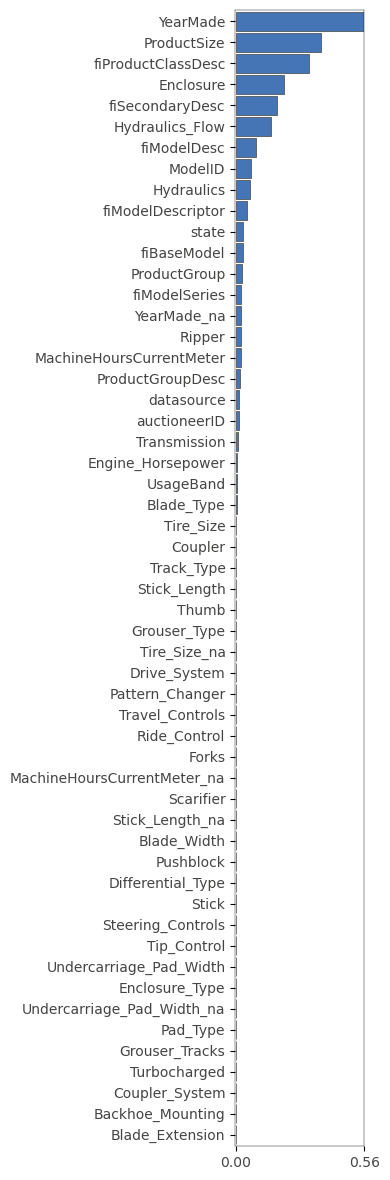

In [57]:
showimp(rf,X,y)

In [58]:
df= df.reset_index(drop=True)
df.to_feather('bulldozer-train-clean.feather')